# Imports

In [29]:
import numpy as np
import pandas as pd
import pylab as p
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import tensorflow as tf
from tensorflow import keras

# Functions Definitions

In [30]:
# display matrix matrix function
def display_metrics_and_confusion_matrix(model_name, y_true, y_pred):
    """
    Displays accuracy, classification report (as a DataFrame), and a confusion matrix heatmap.
    """
    acc = accuracy_score(y_true, y_pred)

    # Convert classification report to DataFrame
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).T

    # Print accuracy
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")

    # Display the classification report as a DataFrame
    display(report_df.style.background_gradient(cmap="Blues").format("{:.2f}"))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [31]:

###############################################################################
# 1. DATA LOADING & PREPROCESSING
###############################################################################
# --- Load MNIST from Keras ---
"""
Loads the MNIST dataset from Keras, flattens the images from (28,28) to (784,),
normalizes pixel values to [0,1], and (optionally) reduces dimensionality using PCA.

Arguments:
    use_pca (bool): Whether to apply PCA for dimensionality reduction.
    pca_variance (float): The variance ratio to keep when applying PCA. E.g., 0.95.

Returns:
    X_train, X_test: Feature arrays (train/test).
    y_train, y_test: Label arrays (train/test).
"""
def load_and_preprocess_data(use_pca=False, pca_variance=0.95):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_train = X_train.reshape((X_train.shape[0], 28 * 28)).astype('float32') / 255.0
    X_test = X_test.reshape((X_test.shape[0], 28 * 28)).astype('float32') / 255.0
    if use_pca:
        pca = PCA(n_components=pca_variance)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test, y_train, y_test

###############################################################################
# 2. BASELINE MODEL: SIMPLE NEURAL NETWORK
###############################################################################
def build_baseline_neural_network(input_dim, num_classes=10):
    """
    Builds a simple feed-forward neural network using Keras Sequential API.

    Arguments:
        input_dim (int): Dimensionality of input features (784 for raw MNIST, or fewer if PCA is used).
        num_classes (int): Number of output classes. Default is 10 for digits [0..9].

    Returns:
        A compiled tf.keras Sequential model.
    """
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

def train_baseline_nn(X_train, y_train, X_test, y_test, epochs=5, batch_size=128):
    """
    Trains the baseline neural network on the training data. Evaluates on the test set.

    Arguments:
        X_train, y_train: Training data and labels.
        X_test, y_test: Test data and labels.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: The trained neural network.
        test_accuracy (float): Accuracy on the test set.
    """
    input_dim = X_train.shape[1]
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    display_metrics_and_confusion_matrix("Baseline NN", y_test, y_pred)
    return model

###############################################################################
# 3. CLASSICAL MACHINE LEARNING MODELS
###############################################################################

# 3.1 KNN
def train_knn(X_train, y_train, X_test, y_test, k=3):
    """
    Trains a K-Nearest Neighbors model and evaluates on the test set.

    Arguments:
        k (int): Number of neighbors.
    """
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    display_metrics_and_confusion_matrix("KNN", y_test, y_pred)
    return knn


# 3.2 SVM
def train_svm(X_train, y_train, X_test, y_test, kernel='rbf'):
    """
    Trains a Support Vector Machine model with the specified kernel.

    Arguments:
        kernel (str): Kernel type ('linear', 'rbf', 'poly', etc.).
    """
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    display_metrics_and_confusion_matrix("SVM", y_test, y_pred)
    return svm


# 3.3 Decision Tree
def train_decision_tree(X_train, y_train, X_test, y_test, max_depth=None):
    """
    Trains a Decision Tree classifier.

    Arguments:
        max_depth (int or None): The maximum depth of the tree. If None, no maximum.
    """
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    display_metrics_and_confusion_matrix("Decision Tree", y_test, y_pred)
    return dt

# 3.4 AdaBoost
def train_adaboost(X_train, y_train, X_test, y_test, n_estimators=50):
    """
    Trains an AdaBoost classifier with decision trees as base estimators.

    Arguments:
        n_estimators (int): Number of weak learners.
    """
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators, random_state=42)
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    display_metrics_and_confusion_matrix("AdaBoost", y_test, y_pred)
    return ada


# 3.5 Random Forest
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100):
    """
    Trains a Random Forest classifier.

    Arguments:
        n_estimators (int): Number of trees in the forest.
    """
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    display_metrics_and_confusion_matrix("Random Forest", y_test, y_pred)
    return rf

###############################################################################
# 4. OPTIONAL ENSEMBLE
###############################################################################
def train_ensemble(models, X_test, y_test):
    """
    Simple demonstration of a majority-voting ensemble.
    `models` is a list of trained (model_name, model) tuples.
    We'll do a simple majority vote on predictions.
    """
    predictions = [model.predict(X_test).reshape(-1, 1) for _, model in models]
    predictions = np.concatenate(predictions, axis=1)
    final_preds = [np.bincount(row).argmax() for row in predictions]
    display_metrics_and_confusion_matrix("Ensemble Majority Voting", y_test, final_preds)
    return np.array(final_preds)


###############################################################################
# 5. EVALUATION FUNCTIONS
###############################################################################
def print_metrics_and_confusion_matrix(model_name, y_true, y_pred):
    """
    Prints accuracy, classification report, and confusion matrix.
    """
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


In [32]:
# --- Load data with optional PCA ---
# Set use_pca=True to reduce dimensionality to 95% variance
X_train, X_test, y_train, y_test = load_and_preprocess_data(use_pca=False, pca_variance=0.95)

C:\Program Files\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5
469/469 - 4s - 8ms/step - accuracy: 0.9075 - loss: 0.3292
Epoch 2/5
469/469 - 3s - 6ms/step - accuracy: 0.9587 - loss: 0.1380
Epoch 3/5
469/469 - 2s - 4ms/step - accuracy: 0.9710 - loss: 0.0977
Epoch 4/5
469/469 - 2s - 5ms/step - accuracy: 0.9785 - loss: 0.0731
Epoch 5/5
469/469 - 2s - 4ms/step - accuracy: 0.9820 - loss: 0.0579
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Baseline NN ===
Accuracy: 0.9749


,precision,recall,f1-score,support
0,0.99,0.98,0.98,980.00
1,0.99,0.99,0.99,1135.00
2,0.98,0.97,0.98,1032.00
3,0.96,0.98,0.97,1010.00
4,0.98,0.98,0.98,982.00
5,0.95,0.98,0.97,892.00
6,0.96,0.98,0.97,958.00
7,0.97,0.98,0.97,1028.00
8,0.98,0.95,0.97,974.00
9,0.99,0.95,0.97,1009.00


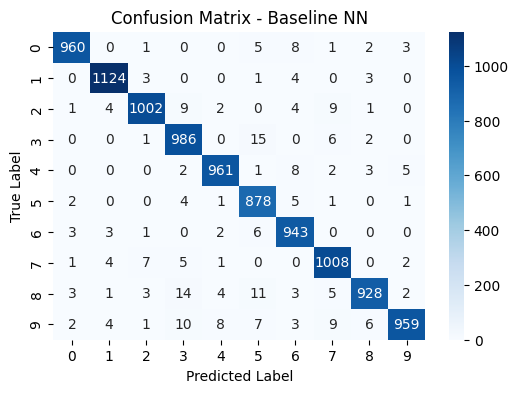

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Baseline NN ===
Accuracy: 0.9749
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.95      0.98      0.97       892
           6       0.96      0.98      0.97       958
           7       0.97      0.98      0.97      1028
           8       0.98      0.95      0.97       974
           9       0.99      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.97      0.97     10000

Confusion Matrix:
[[ 960    0    1    0    0    5    8    1    2    3]
 [   0 1124    3    0    0    1    4    0    3    0]
 [   1    4 100

In [33]:
# --- Baseline Neural Network ---
nn_model= train_baseline_nn(X_train, y_train, X_test, y_test, epochs=5, batch_size=128)
# We can get predictions for evaluation
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
# print_metrics_and_confusion_matrix("Baseline NN", y_test, y_pred_nn)



=== KNN ===
Accuracy: 0.9705


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.96,1.00,0.98,1135.00
2,0.98,0.97,0.97,1032.00
3,0.96,0.97,0.96,1010.00
4,0.98,0.97,0.97,982.00
5,0.97,0.96,0.96,892.00
6,0.98,0.99,0.98,958.00
7,0.96,0.96,0.96,1028.00
8,0.99,0.94,0.96,974.00
9,0.96,0.96,0.96,1009.00


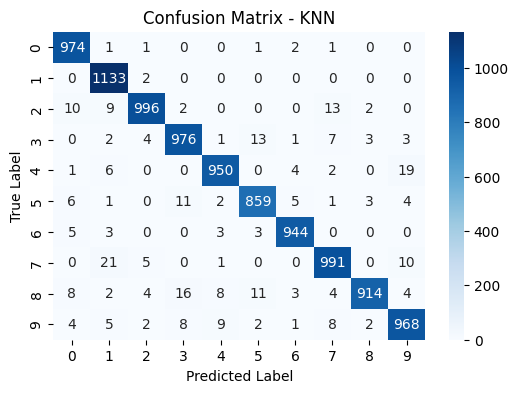

In [34]:

# --- KNN ---
knn_model = train_knn(X_train, y_train, X_test, y_test, k=3)
y_pred_knn = knn_model.predict(X_test)
# print_metrics_and_confusion_matrix("KNN", y_test, y_pred_knn)



=== SVM ===
Accuracy: 0.9792


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.98,0.97,0.98,1032.00
3,0.97,0.99,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.98,0.97,0.97,1028.00
8,0.97,0.98,0.97,974.00
9,0.97,0.96,0.97,1009.00


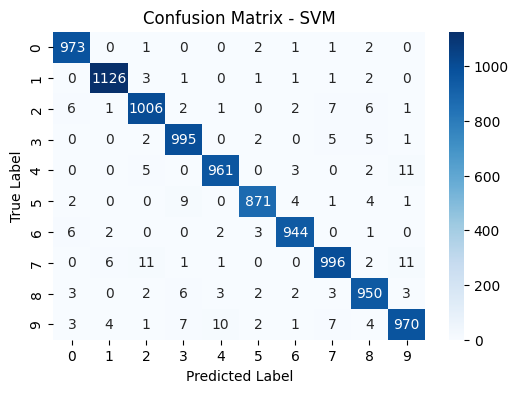

In [25]:

# --- SVM ---
svm_model = train_svm(X_train, y_train, X_test, y_test, kernel='rbf')
y_pred_svm = svm_model.predict(X_test)
# print_metrics_and_confusion_matrix("SVM (RBF)", y_test, y_pred_svm)



=== Decision Tree ===
Accuracy: 0.8663


,precision,recall,f1-score,support
0,0.91,0.94,0.92,980.00
1,0.95,0.96,0.95,1135.00
2,0.85,0.84,0.84,1032.00
3,0.82,0.84,0.83,1010.00
4,0.86,0.85,0.86,982.00
5,0.84,0.80,0.82,892.00
6,0.91,0.87,0.89,958.00
7,0.90,0.88,0.89,1028.00
8,0.80,0.81,0.80,974.00
9,0.81,0.86,0.83,1009.00


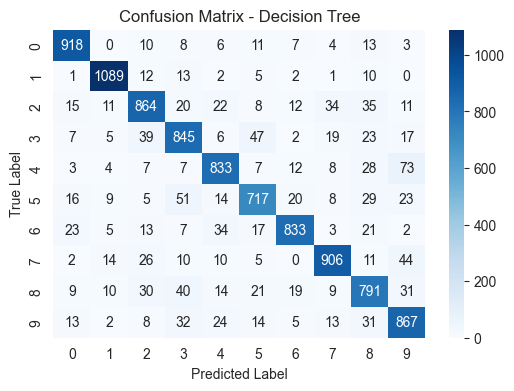

In [7]:

# --- Decision Tree ---
dt_model = train_decision_tree(X_train, y_train, X_test, y_test, max_depth=10)
y_pred_dt = dt_model.predict(X_test)
# print_metrics_and_confusion_matrix("Decision Tree", y_test, y_pred_dt)



=== AdaBoost ===
Accuracy: 0.5756


,precision,recall,f1-score,support
0,0.90,0.60,0.72,980.00
1,0.90,0.32,0.48,1135.00
2,0.56,0.67,0.61,1032.00
3,0.44,0.65,0.53,1010.00
4,0.50,0.51,0.50,982.00
5,0.46,0.50,0.48,892.00
6,0.82,0.70,0.76,958.00
7,0.69,0.60,0.64,1028.00
8,0.52,0.75,0.62,974.00
9,0.43,0.47,0.45,1009.00


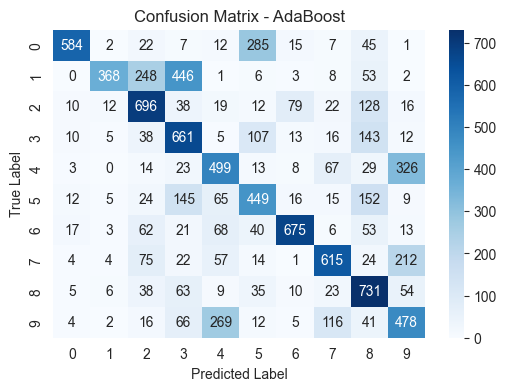

In [8]:

# --- AdaBoost ---
ada_model = train_adaboost(X_train, y_train, X_test, y_test, n_estimators=50)
y_pred_ada = ada_model.predict(X_test)
# print_metrics_and_confusion_matrix("AdaBoost", y_test, y_pred_ada)



=== Random Forest ===
Accuracy: 0.9704


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.99,0.99,0.99,1135.00
2,0.96,0.97,0.97,1032.00
3,0.96,0.96,0.96,1010.00
4,0.97,0.97,0.97,982.00
5,0.98,0.96,0.97,892.00
6,0.98,0.98,0.98,958.00
7,0.97,0.96,0.97,1028.00
8,0.96,0.95,0.96,974.00
9,0.96,0.95,0.96,1009.00


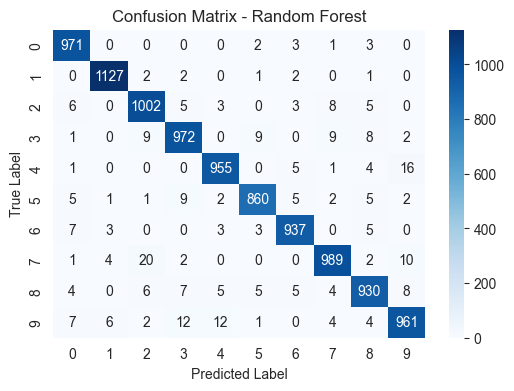

In [9]:

# --- Random Forest ---
rf_model = train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100)
y_pred_rf = rf_model.predict(X_test)
# print_metrics_and_confusion_matrix("Random Forest", y_test, y_pred_rf)



=== Ensemble Majority Voting ===
Accuracy: 0.9791


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.99,0.99,0.99,1135.00
2,0.97,0.98,0.98,1032.00
3,0.97,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.98,0.95,0.97,1009.00


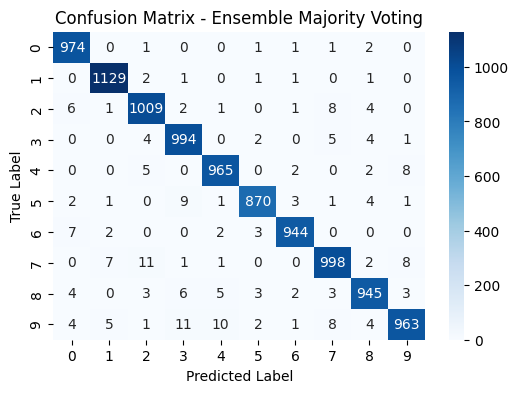

In [30]:

# --- Ensemble (Majority Voting) ---
# Here we combine the trained models above
# You can also combine fewer or more, or use VotingClassifier from sklearn
models_list = [
    ("KNN", knn_model),
    ("SVM", svm_model),
    ("SVM", svm_model),
    # ("DT", dt_model),
    # ("Ada", ada_model),
    ("RF", rf_model)
    # If desired, you can also integrate the NN by converting its predictions 
    # to a scikit-learn style predictor, but that requires a small wrapper.
]
ensemble_preds = train_ensemble(models_list, X_test, y_test)
# print_metrics_and_confusion_matrix("Ensemble Majority Voting", y_test, ensemble_preds)



=== Ensemble Majority Voting ===
Accuracy: 0.9785


,precision,recall,f1-score,support
0,0.97,0.99,0.98,980.00
1,0.98,0.99,0.99,1135.00
2,0.97,0.98,0.98,1032.00
3,0.97,0.98,0.98,1010.00
4,0.98,0.98,0.98,982.00
5,0.99,0.97,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.97,974.00
9,0.98,0.96,0.97,1009.00


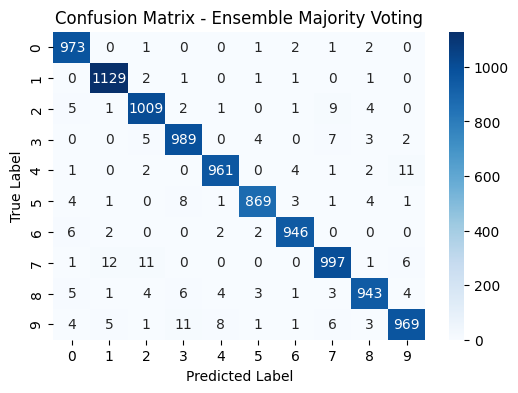

In [40]:

# --- Ensemble (Majority Voting) ---
# Here we combine the trained models above
# You can also combine fewer or more, or use VotingClassifier from sklearn
models_list = [
    ("KNN", knn_model),
    ("SVM", svm_model),
    # ("DT", dt_model),
    # ("Ada", ada_model),
    ("RF", rf_model)
    # If desired, you can also integrate the NN by converting its predictions 
    # to a scikit-learn style predictor, but that requires a small wrapper.
]
ensemble_preds = train_ensemble(models_list, X_test, y_test)
# print_metrics_and_confusion_matrix("Ensemble Majority Voting", y_test, ensemble_preds)


In [53]:

def dynamic_weighted_ensemble(models, X_test, y_test, custom_weights=None):
    """
    Combines predictions from multiple models using dynamically assigned weights per class.

    Arguments:
        models (list): List of trained models.
        X_test (array-like): Test feature set.
        y_test (array-like): True labels.
        custom_weights (list of dicts, optional): A list where each dictionary contains class-specific weights for a model.
    Returns:
        y_final_pred: Final predictions using dynamically weighted voting.
    """
    all_probs = []
    num_classes = len(np.unique(y_test))
    class_counts = np.bincount(y_test, minlength=num_classes)

    for model in models:
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)
        else:
            preds = model.predict(X_test)
            probs = np.zeros((len(preds), num_classes))
            probs[np.arange(len(preds)), preds] = 1  # Convert to one-hot
        all_probs.append(probs)

    # Use provided custom weights if available, otherwise compute class-specific weights dynamically
    weights = []
    if custom_weights:
        for w in custom_weights:
            weights.append(np.array([w.get(cls, 0) for cls in range(num_classes)]))
    else:
        for model in models:
            preds = model.predict(X_test)
            model_weights = np.zeros(num_classes)
            for cls in range(num_classes):
                model_weights[cls] = np.sum(preds == cls) / class_counts[cls] if class_counts[cls] > 0 else 0
            weights.append(model_weights)

    # Compute weighted probabilities
    final_probs = np.zeros_like(all_probs[0])
    for probs, weight in zip(all_probs, weights):
        final_probs += probs * weight  # Apply class-specific weighting

    # Get final class predictions
    y_final_pred = np.argmax(final_probs, axis=1)

    # Evaluate model performance
    display_metrics_and_confusion_matrix("Dynamic Weighted Ensemble", y_test, y_final_pred)
    return y_final_pred



=== Dynamic Weighted Ensemble ===
Accuracy: 0.9807


,precision,recall,f1-score,support
0,0.98,0.99,0.99,980.00
1,0.98,0.99,0.99,1135.00
2,0.98,0.98,0.98,1032.00
3,0.98,0.99,0.98,1010.00
4,0.99,0.98,0.98,982.00
5,0.99,0.98,0.98,892.00
6,0.99,0.99,0.99,958.00
7,0.97,0.97,0.97,1028.00
8,0.98,0.97,0.98,974.00
9,0.98,0.97,0.97,1009.00


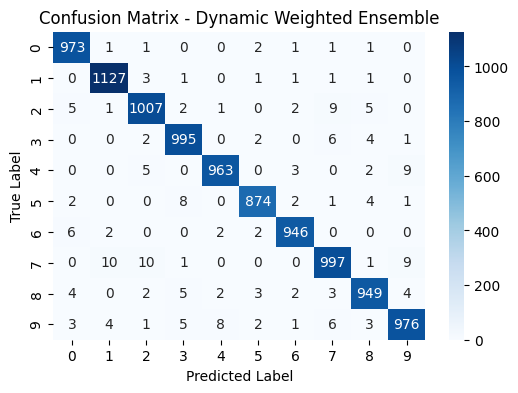

In [46]:
models = [svm_model, knn_model, rf_model]  # List of trained models
# weights = [{0: 0.6, 1: 0.4, 2: 0.8}, {0: 0.5, 1: 0.5, 2: 0.7}, {0: 0.7, 1: 0.3, 2: 0.9}]  # Example weights per class
y_dynamic_weighted_ensemble = dynamic_weighted_ensemble(models, X_test, y_train)


In [69]:
# todo: change!

def dynamic_weighted_ensemble2(models, X_test, y_test, custom_weights=None):
    """
    Combines predictions from multiple models using dynamically assigned weights per class.

    Arguments:
        models (list): List of trained models.
        X_test (array-like): Test feature set.
        y_test (array-like): True labels.
        custom_weights (list of dicts, optional): A list where each dictionary contains class-specific weights for a model.

    Returns:
        y_final_pred: Final predictions using dynamically weighted voting.
    """
    all_probs = []
    num_classes = len(np.unique(y_test))  # Get number of unique classes dynamically

    # Initialize the final prediction list
    final_pred = [0] * len(X_test)

    for model_idx, model in enumerate(models):
        if hasattr(model, "predict_proba"):
            # Predict probabilities if available
            probs = model.predict_proba(X_test)
        else:
            # For models without predict_proba, predict class labels
            preds = model.predict(X_test)
            # Convert to one-hot encoding
            probs = np.zeros((len(preds), num_classes))
            probs[np.arange(len(preds)), preds] = 1
        all_probs.append(probs)

    # For each instance in the test set
    for i in range(len(X_test)):
        classify = np.zeros(num_classes)

        # Combine predictions from all models
        for j in range(len(models)):
            # Get class probabilities or class predictions
            if hasattr(models[j], "predict_proba"):
                # Weight the probabilities for each class (model's contribution is based on its probability)
                for class_idx in range(num_classes):
                    classify[class_idx] += all_probs[j][i, class_idx] * custom_weights[j].get(class_idx, 0)
            else:
                # For models with no probabilities, weight the predicted class labels (simple voting)
                predicted_class = np.argmax(all_probs[j][i])  # We use the highest probability as the predicted class
                classify[predicted_class] += custom_weights[j].get(predicted_class, 0)

        # Select the class with the highest weighted sum
        final_pred[i] = np.argmax(classify)

    # Evaluate model performance (assuming display_metrics_and_confusion_matrix is implemented elsewhere)
    display_metrics_and_confusion_matrix("Dynamic Weighted Ensemble", y_test, final_pred)

    return final_pred

# Example usage:



In [70]:

models = [svm_model, knn_model, rf_model]  # List of trained models
weights = [
    {0: 0.4, 1: 0.4, 2: 0.4, 3: 0.6, 4: 0.4, 5: 0.6, 6: 0.45, 7: 0.3, 8: 0.48, 9: 0.4},  # Weights for model 1
    {0: 0.3, 1: 0.1, 2: 0.5, 3: 0.3, 4: 0.3, 5: 0.1, 6: 0.45, 7: 0.4, 8: 0.26, 9: 0.3},  # Weights for model 2
    {0: 0.3, 1: 0.5, 2: 0.1, 3: 0.1, 4: 0.3, 5: 0.3, 6: 0.1, 7: 0.4, 8: 0.26, 9: 0.3}   # Weights for model 3
]

y_dynamic_weighted_ensemble = dynamic_weighted_ensemble2(models, X_test, y_test, custom_weights=weights)


TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.


=== KNN ===
Accuracy: 0.9328


,precision,recall,f1-score,support
0,0.97,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.94,0.93,0.94,1032.00
3,0.93,0.95,0.94,1010.00
4,0.96,0.96,0.96,982.00
5,0.93,0.93,0.93,892.00
6,0.84,0.86,0.85,958.00
7,0.92,0.94,0.93,1028.00
8,0.99,0.91,0.95,974.00
9,0.86,0.86,0.86,1009.00


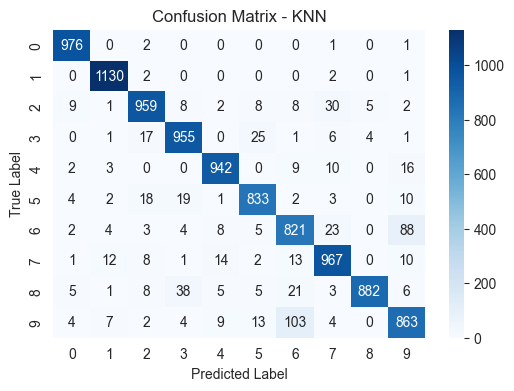

In [22]:
import importlib
import basic_models

import transformations as trans; importlib.reload(trans)
from transformations import fourier_transform_features_arr as ftf_arr
X_train_non_flat,X_test_non_flat,Y_train_non_flat,Y_test_non_flat = basic_models.load_preprocess_mnist_data(scale_features=False,flatten_image=False)
f_X_test = ftf_arr(X_test_non_flat)
f_X_train = ftf_arr(X_train_non_flat)
f_X_test = [p.flat for p in f_X_test]
f_X_train = [p.flat for p in f_X_train]


knn_model_fourier = train_knn(f_X_train, Y_train_non_flat, f_X_test, Y_test_non_flat, k=3)



In [29]:
import importlib
import basic_models

import transformations as trans; importlib.reload(trans)
from transformations import fourier_transform_features_arr as ftf_arr

combine_test = []
for i in range(0,len(X_test)):
    combine_test.append(np.append(f_X_test[i], X_test[i]))
combine_train = []
for i in range(0,len(X_train)):
    combine_train.append(np.append(f_X_train[i], X_train[i]))

knn_model_fourier = train_knn(combine_train, Y_train_non_flat, combine_test, Y_test_non_flat, k=3)

KeyboardInterrupt: 

In [20]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics import *
def cosine_distance(vec1, vec2):
    return cosine_distances([vec1], [vec2])[0][0]


=== KNN With Cosine Distance ===
Accuracy: 0.9733


,precision,recall,f1-score,support
0,0.96,1.00,0.98,980.00
1,0.97,1.00,0.98,1135.00
2,0.98,0.97,0.98,1032.00
3,0.97,0.97,0.97,1010.00
4,0.98,0.96,0.97,982.00
5,0.97,0.96,0.97,892.00
6,0.98,0.99,0.98,958.00
7,0.98,0.97,0.97,1028.00
8,0.98,0.96,0.97,974.00
9,0.95,0.96,0.96,1009.00


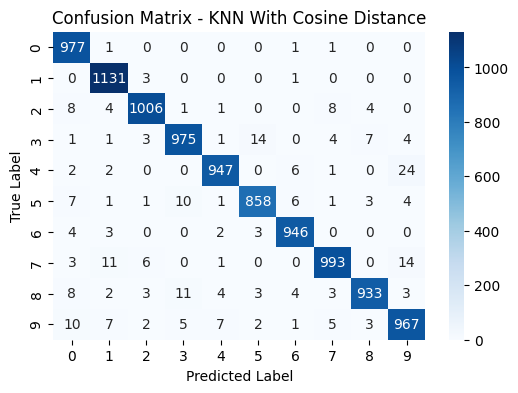

In [21]:
knn_cosine = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_cosine.fit(X_train, y_train)
y_pred_cosine = knn_cosine.predict(X_test)
display_metrics_and_confusion_matrix("KNN With Cosine Distance", y_test, y_pred_cosine)

In [22]:
#tangent distance#

In [41]:
import numpy as np
import pandas as pd
import random as rd
import struct
from PIL import Image




In [45]:
def readMNISTdata(ubyte_file, status):
    with open(ubyte_file, 'rb') as f:
        buf = f.read()
    offset = 0

    if status == 'data':
        magic, imageNum, rows, cols = struct.unpack_from('>IIII', buf, offset)
        offset += struct.calcsize('>IIII')
        imageSize = rows * cols
        images = np.empty((imageNum,imageSize))
        fmt = '>' + str(imageSize) + 'B'
        for i in range(imageNum):
            images[i] = np.array(struct.unpack_from(fmt, buf, offset))
            offset += struct.calcsize(fmt)
        return images
    elif status == 'label':
        magic, LabelNum = struct.unpack_from('>II', buf, offset)
        offset += struct.calcsize('>II')
        Labels = np.zeros((LabelNum))
        for i in range(LabelNum):
            Labels[i] = np.array(struct.unpack_from('>B', buf, offset))
            offset += struct.calcsize('>B')
        return Labels
    else: return -1

In [46]:
def Cos_distance(x,y):
    dist = np.dot(x,y)/np.linalg.norm(x)/np.linalg.norm(y)
    return

def Man_distance(x,y):
    dist = np.linalg.norm(x-y, ord=1)
    return dist

def Euc_distance(x,y):
    dist = np.linalg.norm(x-y)
    return dist

In [49]:
def KNN_tangent(train_images, train_labels, test_images, test_labels):
    train_size = train_labels.size
    test_size = test_labels.size
    count = 0
    learning_rate = 6e-7
    training_epochs = 50
    for i in range(test_size):
        # Unit vector for each test point
        #Tr=np.zeros((784,3))
        pattern = test_images[i,...].reshape((28,28))
        pattern_x = np.hstack((np.zeros((28,1)),pattern[...,0:27]))
        pattern_y = np.vstack((pattern[1:,...],np.zeros((1,28))))
        #Rotate the image by 3 degrees
        img = pattern.astype(np.uint8)
        img = Image.fromarray(img)
        pattern_r = np.array(img.rotate(3))
        Tr = np.hstack((pattern_x.reshape((784,1))-test_images[i,...].reshape((784,1)), \
                              pattern_y.reshape((784,1))-test_images[i,...].reshape((784,1)), \
                              pattern_r.reshape((784,1))-test_images[i,...].reshape((784,1))))
        # Tangent distance
        distances = np.zeros(train_size)
        for j in range(train_size):
            alpha = np.zeros((3,1))
            # Gradient descent
            for ite in range(training_epochs):
                alpha = alpha - learning_rate*np.matmul(Tr.T,(test_images[i,...].reshape((784,1))+np.matmul(Tr,alpha)-train_images[j,...].reshape((784,1))))
            distances[j] = Euc_distance(test_images[i,...].T+np.matmul(Tr,alpha), train_images[j,...].T)
        index = np.argsort(distances)
        predict = train_labels[index[0]]
        if predict == test_labels[i]:
            count = count + 1
    acc = count / test_size
    return acc

acc = KNN_tangent(X_train,y_train,X_test[:10],y_test[:10])
print(acc)


KeyboardInterrupt: 